<a href="https://colab.research.google.com/github/danielnaranjo144/Hands-on-Computer-Vision/blob/main/sesiones/sesion9/Sesion9_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<image src="https://i.imgur.com/m2xbBCS.jpeg" width=100%>

# <font color="00CED1"><center> **Hands-On Sesión 9: Imágenes Térmicas 📚🌡️** </center></font>

## Multimodal Vision-Language Transformer for Thermography Breast Cancer Classification

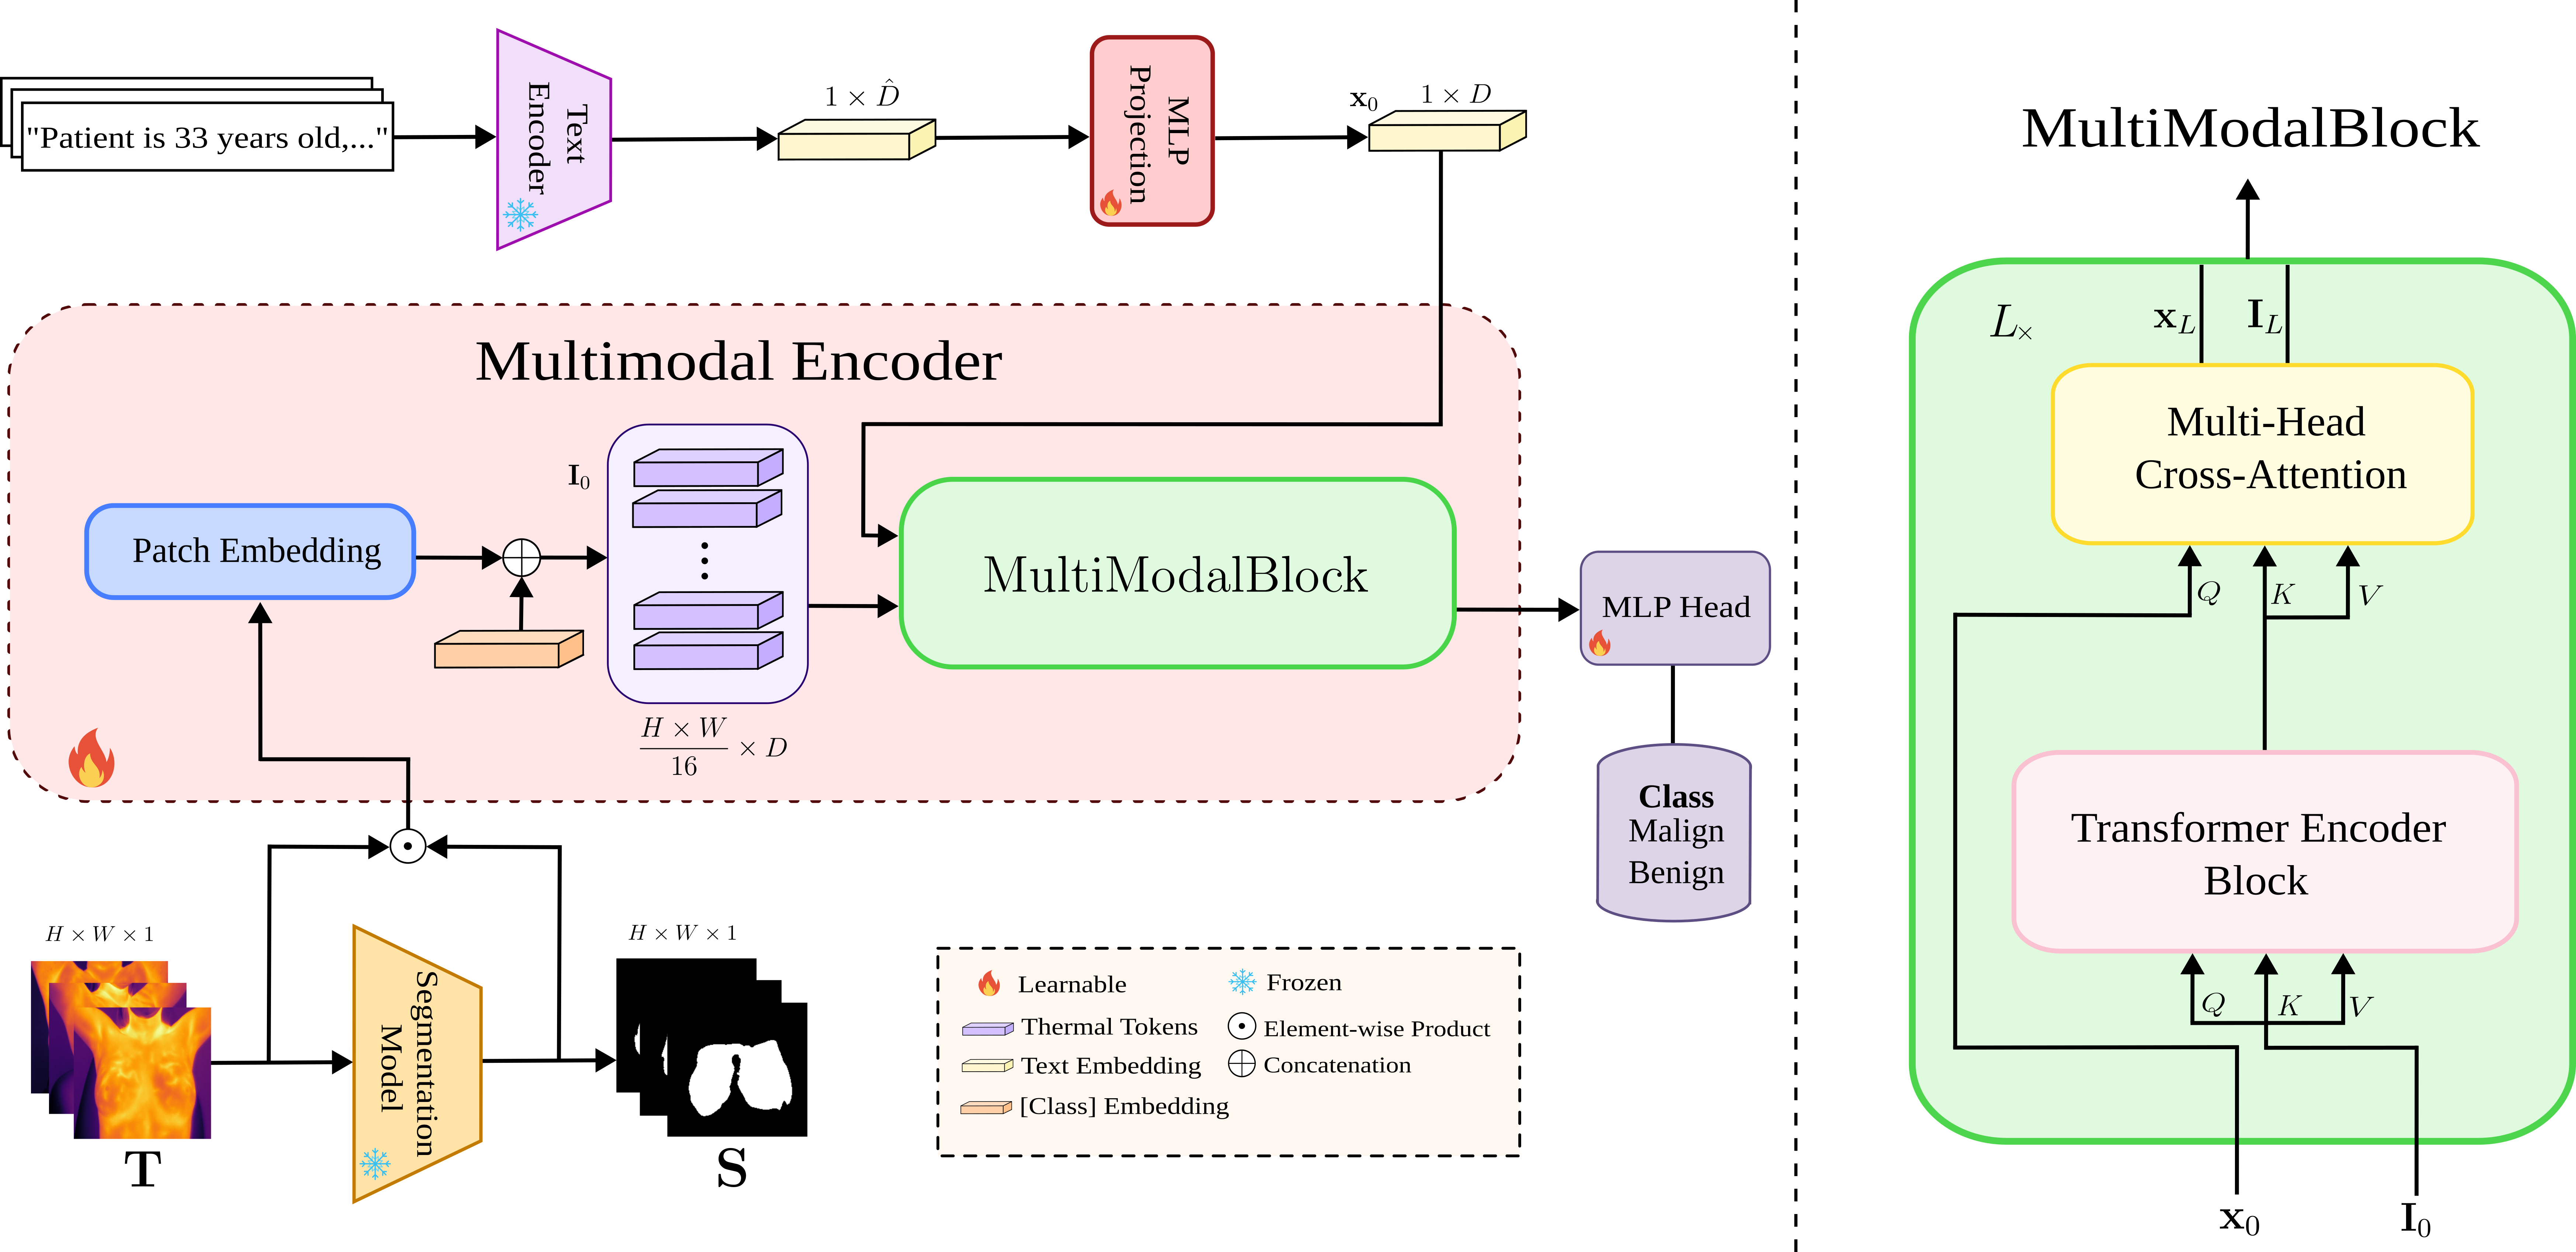

In [1]:
%%capture
! pip install datasets ml_collections

In [2]:
! git clone https://github.com/semilleroCV/BreastCATT.git
%cd BreastCATT

Cloning into 'BreastCATT'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 283 (delta 73), reused 71 (delta 46), pack-reused 176 (from 1)
Receiving objects: 100% (283/283), 2.76 MiB | 4.32 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/BreastCATT


In [3]:
#@title 1. Importamos dependencias

import json
import torch
from huggingface_hub import hf_hub_download
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Lambda

In [4]:
from breastcatt.tfvit import MultiModalVisionTransformer

In [6]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#@title 2. Define tu repo y descarga los archivos
repo_id = "SemilleroCV/tfvit-small_seg_text"
config_path = hf_hub_download(repo_id=repo_id, filename="config.json")
state_dict_path = hf_hub_download(repo_id=repo_id, filename="pytorch_model.bin")

In [ ]:
with open(config_path, "r") as f:
    init_args = json.load(f)

In [ ]:
#@title N. Cargamos el modelo que realiza la segmentación

from huggingface_hub import hf_hub_download
import os

# Local directory where you want the checkpoint saved
save_path = "/content/BreastCATT/checkpoints/segmentation"
os.makedirs(save_path, exist_ok=True)

# Download the file
checkpoint_path = hf_hub_download(
    repo_id="SemilleroCV/transunet-breast-cancer",
    filename="lucky-sweep-6_0.4937.pth",
    local_dir=save_path
)

In [ ]:
# 4. Instancia tu modelo EXACTO tal cual lo definiste
#    MultiModalVisionTransformer toma como kwargs:
#    embed_dim, use_cross_attn, use_segmentation, num_heads, in_chans,
#    num_classes, cross_num_heads, fusion_alpha, depth, etc.
model = MultiModalVisionTransformer(**init_args)

In [ ]:
# 2) Carga el dataset
from datasets import load_dataset

ds = load_dataset("SemilleroCV/BreastThermography", split='test', download_mode="force_redownload")

README.md:   0%|          | 0.00/5.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/51.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/72 [00:00<?, ? examples/s]

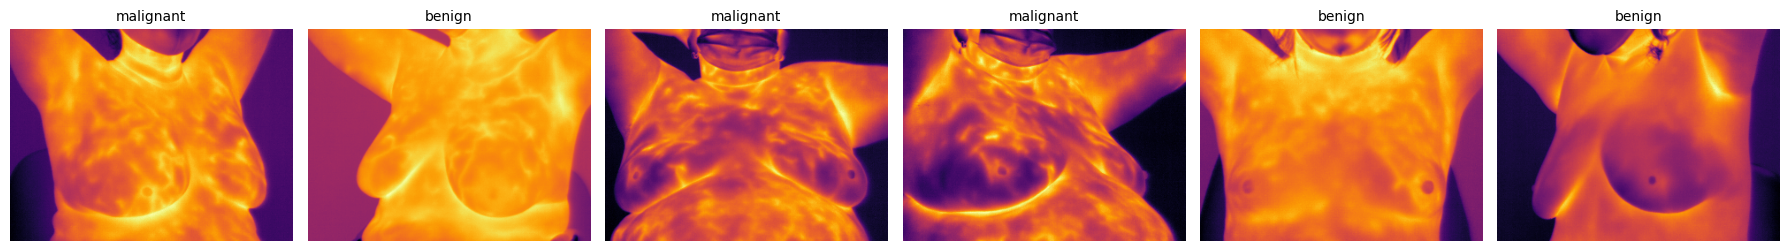

In [ ]:
# 4) Visualiza N imágenes con su etiqueta original
N = 6
samples = ds.shuffle().select(range(N))

fig, axes = plt.subplots(1, N, figsize=(3*N, 4))
for ax, ex in zip(axes, samples):
    # 'image' es un objeto PIL.Image porque datasets detecta la columna como image
    img = ex["image"]
    img = np.array(img, dtype=np.float32)
    label = ex["label"]
    # si tienes mapping a nombres:
    label_name = ds.features["label"].int2str(label)

    ax.imshow(img, cmap='inferno')
    ax.set_title(label_name, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# 3) Define la transformación (redimensiona, tensoriza y normaliza entre 0–1)
min_max_norm = Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8))
data_transform = Compose([
    Resize((224, 224)),
    ToTensor(),      # de PIL a Tensor C×H×W en [0,1]
    min_max_norm,    # normaliza al rango [0,1]
])

In [ ]:
# 4) Prepara el modelo y el dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

MultiModalVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (language_model): LanguageModel(
    (model_lm): MegatronBertModel(
      (embeddings): MegatronBertEmbeddings(
        (word_embeddings): Embedding(50176, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): MegatronBertEncoder(
        (layer): ModuleList(
          (0-23): 24 x MegatronBertLayer(
            (attention): MegatronBertAttention(
              (ln): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
              (self): MegatronBertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): L

In [ ]:
# 5) Infiere sobre las mismas muestras
for ex in samples:
    img = ex["image"]
    pixel_values = data_transform(img).unsqueeze(0).to(device)  # [1, C, H, W]

    with torch.no_grad():
        out = model(pixel_values)      # ModelOutput con logits
        logits = out.logits            # shape [1, 1]
        prob = torch.sigmoid(logits).item()

    true_label = ds.features["label"].int2str(ex["label"])
    pred_label = "malignant" if prob > 0.5 else "benign"
    print(f"Verdadero: {true_label} → Predicción: {pred_label} ({prob*100:.1f}%)")

Verdadero: malignant → Predicción: benign (27.6%)
Verdadero: benign → Predicción: benign (27.6%)
Verdadero: malignant → Predicción: benign (27.5%)
Verdadero: malignant → Predicción: benign (27.5%)
Verdadero: benign → Predicción: benign (27.3%)
Verdadero: benign → Predicción: benign (27.5%)


## YOLOv5 (You Only Look Once)

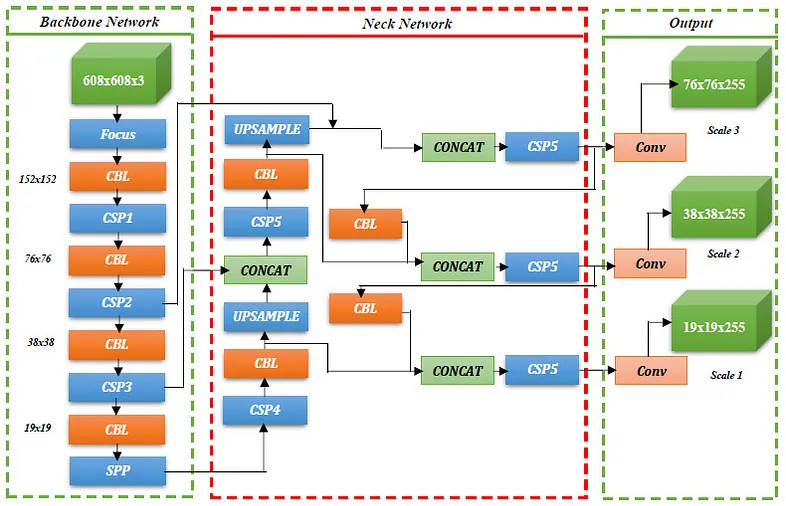

In [ ]:
%%capture
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

In [ ]:
import torch
from matplotlib import pyplot as plt
from PIL import Image
import cv2

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FLIR_01797_jpeg.rf.9ea565e5d7da3810b9dcb66729db6d1e.jpg to FLIR_01797_jpeg.rf.9ea565e5d7da3810b9dcb66729db6d1e.jpg


In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-5-12 Python-3.11.12 torch-2.6.0+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 334MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 480x640 2 persons, 1 bicycle, 1 car
Speed: 77.2ms pre-process, 334.5ms inference, 34.2ms NMS per image at shape (1, 3, 480, 640)


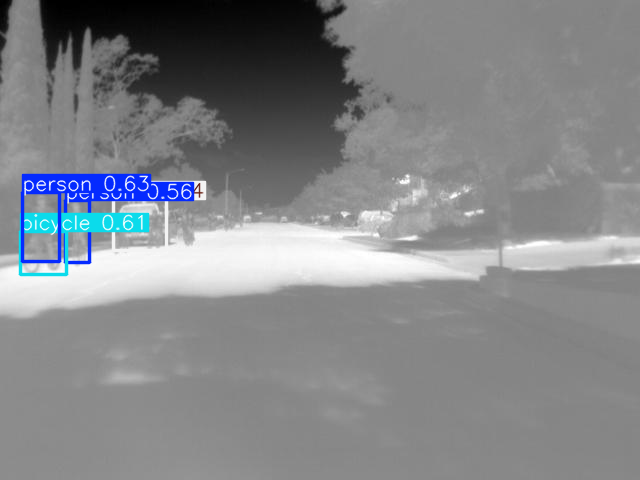

In [ ]:
# Reemplaza con el nombre de tu imagen
img_path = 'FLIR_01797_jpeg.rf.9ea565e5d7da3810b9dcb66729db6d1e.jpg'

# Inferencia
results = model(img_path)

# Mostrar resultados
results.print()
results.show()  # Muestra la imagen con bounding boxes

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io as scio
import os

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl

from torchinfo import summary
from tqdm import tqdm

import sys

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/semilleroCV/deep-thermal-ranging.git
    sys.path.append('./deep-thermal-ranging')
else:
    sys.path.append('..')

/home/guillermo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## HADAR TeX-Net

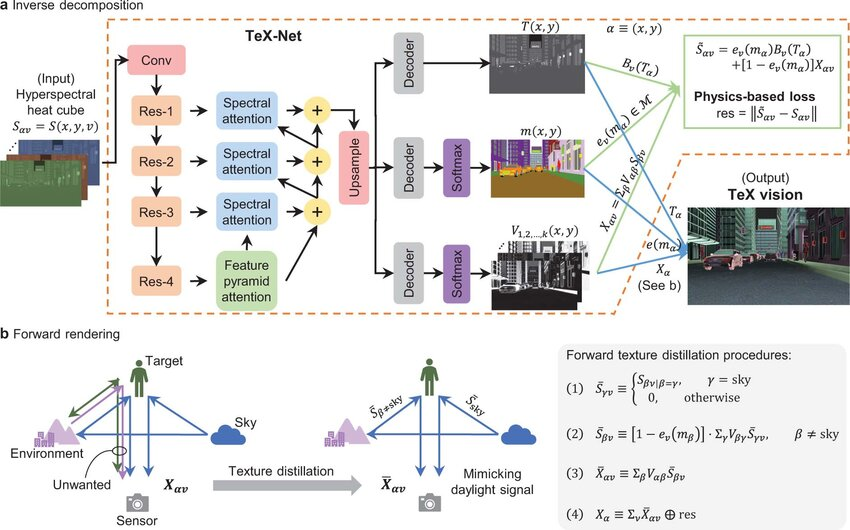

In [ ]:
SUBFOLDERS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
SUBFOLDERS = ["Scene"+str(_) for _ in SUBFOLDERS]
ids = [f"L_{i:04d}" for i in range(1, 6)]
ids += [f"R_{i:04d}" for i in range(1, 6)]

root = 'TeXNet/Dataset'  # Cambia esto a la ruta correcta de tu dataset

print("Starting S_beta preprocessing")
subfolder = SUBFOLDERS[0]
S_files = []
print("Processing subfolder", subfolder)
id = ids[0]
S_file = os.path.join(root, subfolder, 'HeatCubes', f"{id}_heatcube.mat")
S_files.append(S_file)
print(f"Adding S file {S_file}")

img = torch.tensor(np.asarray(scio.loadmat(S_files[0])["S"]))
print(f"Processing S file {S_files[0]}")
print(f"Original shape: {img.shape}")  # Original shape: (1080, 1920, 54)
img = torch.permute(img, (2, 0, 1))
print(f"After permute: {img.shape}")  # Shape after permute: (54, 1080, 1920)
img = torch.reshape(img, (1, 54, 1080, 1920))
print(f"After reshape: {img.shape}")  # Shape after reshape: (1, 54, 1080, 1920)
[b, c, h, w] = img.shape
quadratic_split = F.avg_pool2d(img, (h//2, w))
print(f"After avg_pool2d: {quadratic_split.shape}")  # Shape after avg_pool2d: (1, 54, 2, 1)
mean = quadratic_split.numpy()
print("Mean shape:", mean.shape)

Starting S_beta preprocessing
Processing subfolder Scene1
Adding S file TeXNet/Dataset/Scene1/HeatCubes/L_0001_heatcube.mat
Processing S file TeXNet/Dataset/Scene1/HeatCubes/L_0001_heatcube.mat
Original shape: torch.Size([1080, 1920, 54])
After permute: torch.Size([54, 1080, 1920])
After reshape: torch.Size([1, 54, 1080, 1920])
After avg_pool2d: torch.Size([1, 54, 2, 1])
Mean shape: (1, 54, 2, 1)


### __getitem__

In [ ]:
from texnet.datamodule_newdata import HADARMultipleScenes
# import torchvision.transforms as transforms

# Define the root directory of your dataset
root = 'TeXNet/Dataset'

# Define the split you want to use ('train', 'val', or 'test')
split = 'train'

# Define any input and target transformations you want to apply
# inp_transform = transforms.Compose([
#   # transforms.ToTensor(),
#   transforms.Normalize(mean=[0.5], std=[0.5])
# ])
inp_transform = None
target_transform = None

# Instantiate the HADARMultipleScenes dataset
dataset = HADARMultipleScenes(root=root, split=split, inp_transform=inp_transform, target_transform=target_transform)

# Print the number of samples in the dataset
print(f"Number of samples in {split} dataset: {len(dataset)}")

# Get a sample from the dataset
sample_idx = 0
S_beta, S, (tMap, eMap, vMap) = dataset[sample_idx]

# Print the shapes of the sample data
print(f"S_beta shape: {S_beta.shape}")
print(f"S shape: {S.shape}")
print(f"tMap shape: {tMap.shape}")
print(f"eMap shape: {eMap.shape}")
print(f"vMap shape: {vMap.shape}")

Fold is None for split train
IDs for train are ['L_0002', 'L_0003', 'L_0004', 'R_0002', 'R_0003', 'R_0004'] for synthetic data and ['L_0002', 'L_0003', 'L_0004', 'R_0002', 'R_0003', 'R_0004'] for experimental data
Number of samples in train dataset: 66
S_beta shape: torch.Size([49, 2])
S shape: torch.Size([49, 256, 256])
tMap shape: torch.Size([256, 256])
eMap shape: torch.Size([256, 256])
vMap shape: torch.Size([2, 256, 256])


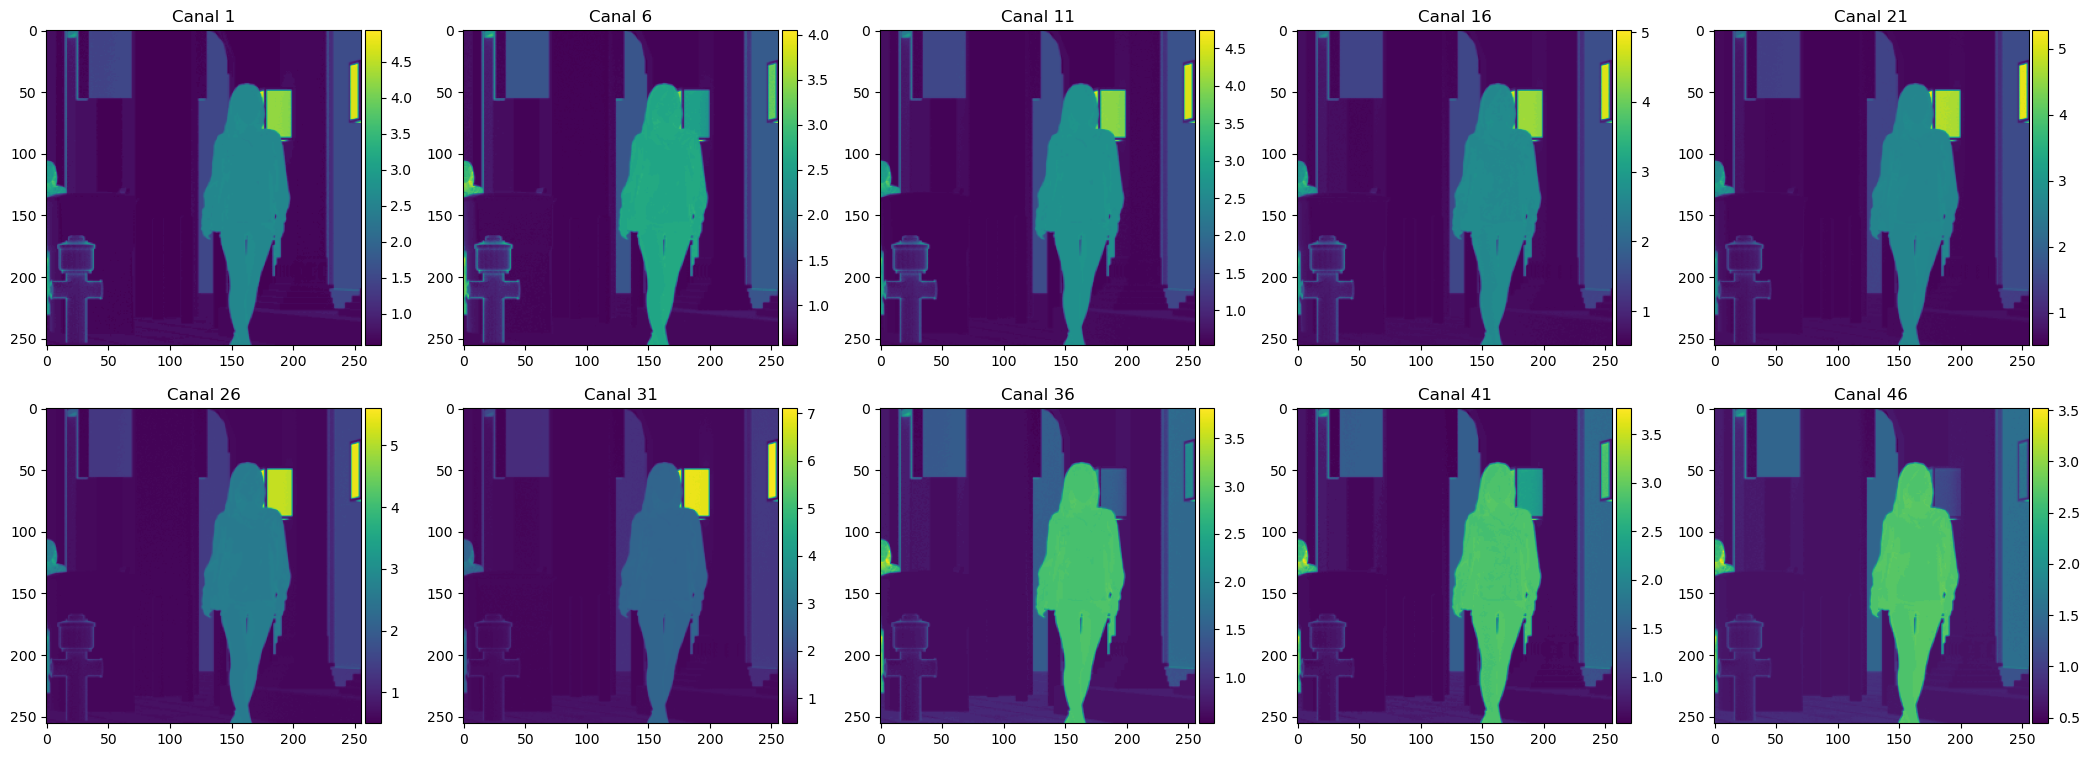

In [ ]:
# Calcular el paso
# s = 49 // 10
s = 5

# Seleccionar 10 canales
selected_channels = list(range(0, 49, s))[:10]

# Plotear 10 de los 49 canales en S
plt.figure(figsize=(26, 9))
for i, channel in enumerate(selected_channels):
  plt.subplot(2, 5, i+1)
  img = plt.imshow(S[channel].numpy(), cmap='viridis')
  plt.title(f'Canal {channel+1}')
  plt.colorbar(img, fraction=0.046, pad=0.01)
plt.show()

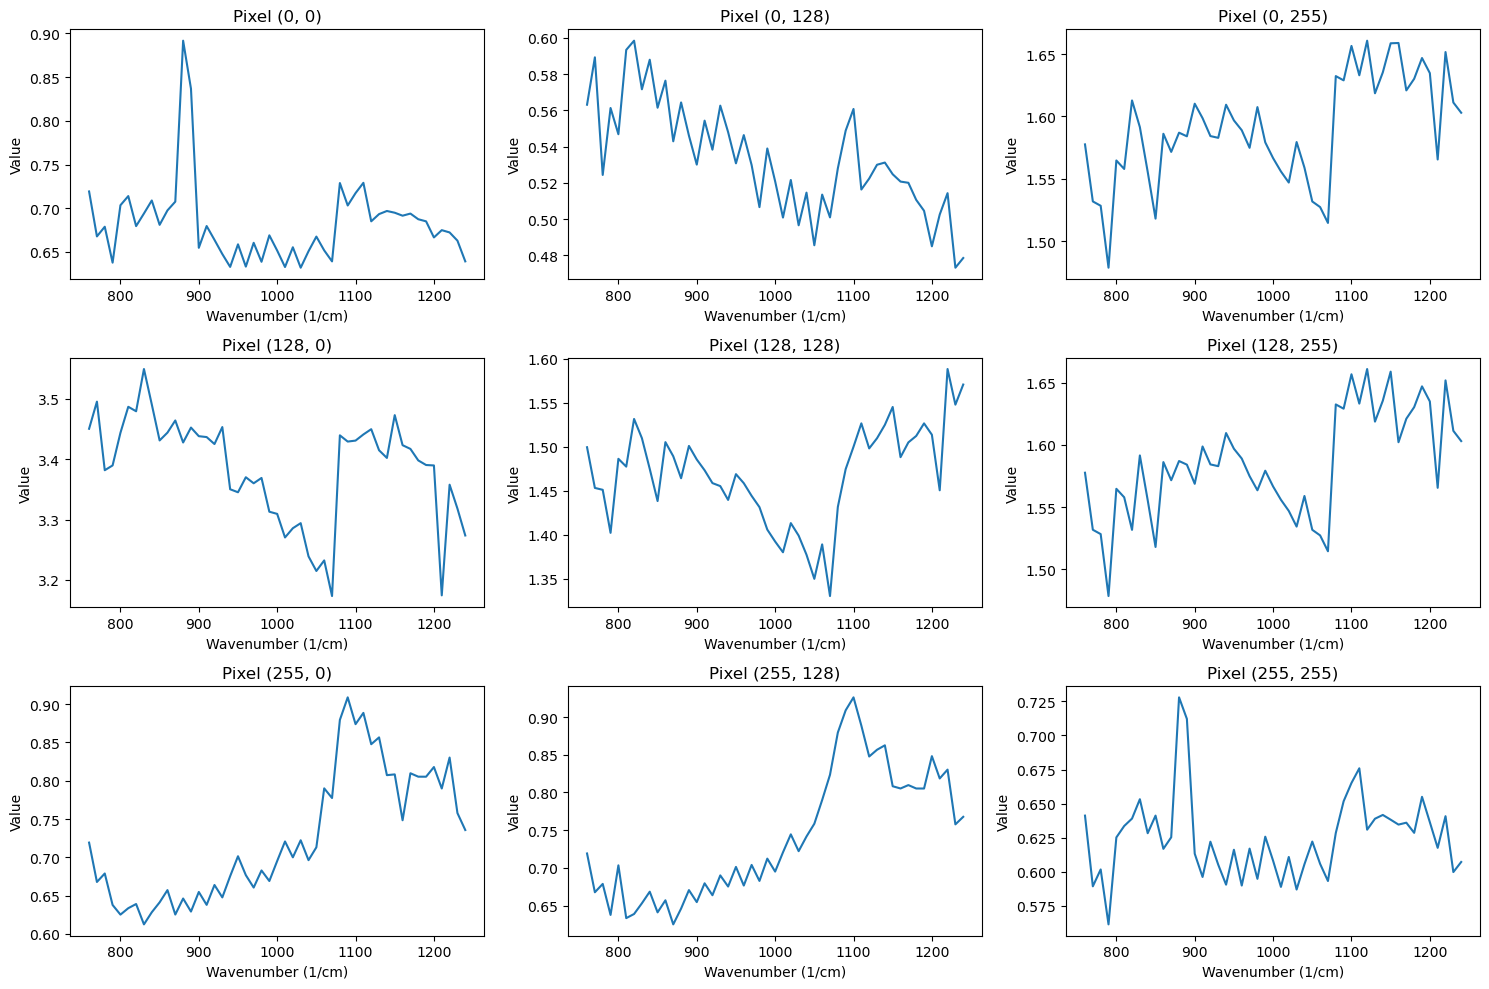

In [ ]:
# Crear el array de wavenumbers
wavenumbers = np.arange(760, 1250, 10)  # Desde 760 hasta 1240 en incrementos de 10

[c, h, w] = S.shape

# Definir las posiciones de los píxeles a plotear
positions = [(0, 0), (0, w//2), (0, w-1), (h//2, 0), (h//2, w//2), (h//2, w-1), (h-1, 0), (h-1, w//2), (h-1, w-1)]

# Crear la figura
plt.figure(figsize=(15, 10))

# Iterar sobre las posiciones y plotear las firmas espectrales
for i, (y, x) in enumerate(positions):
  plt.subplot(3, 3, i+1)
  plt.plot(wavenumbers, S[:, y, x].numpy())
  plt.title(f'Pixel ({y}, {x})')
  plt.xlabel('Wavenumber (1/cm)')
  plt.ylabel('W * cm * m^-2 * sr^-1')

plt.tight_layout()
plt.show()

Las unidades de las firmas espectrales son W * cm * m^-2 * sr^-1. Se puede confirmar [acá](https://purdue0-my.sharepoint.com/personal/sjape_purdue_edu/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Fsjape%5Fpurdue%5Fedu%2FDocuments%2FHADAR%2FHADAR%2FHADAR%20database%2Fblackbodyradiation%2Em&parent=%2Fpersonal%2Fsjape%5Fpurdue%5Fedu%2FDocuments%2FHADAR%2FHADAR%2FHADAR%20database)

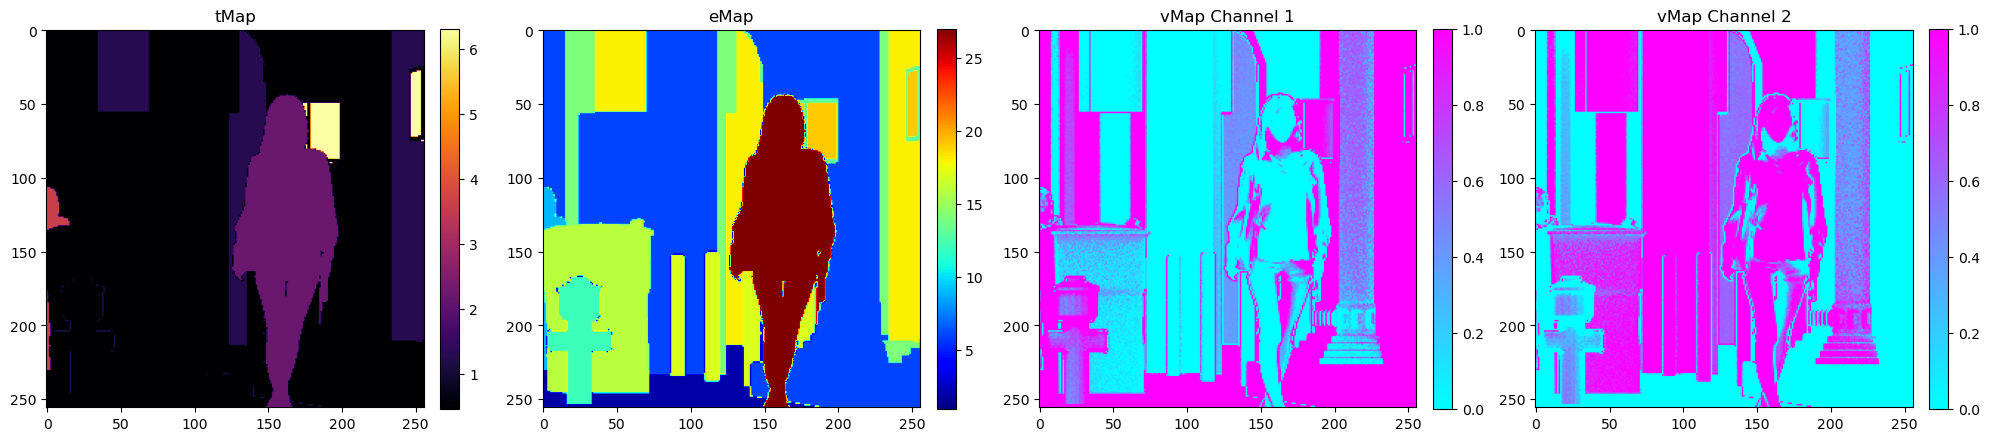

In [ ]:
# Crear una figura con 1 fila y 4 columnas
plt.figure(figsize=(20, 5))

# Plotear tMap
plt.subplot(1, 4, 1)
plt.imshow(tMap.numpy(), cmap='inferno')
plt.title('tMap')
plt.colorbar(fraction=0.046, pad=0.04)

# Plotear eMap
plt.subplot(1, 4, 2)
plt.imshow(eMap.numpy(), cmap='jet')
plt.title('eMap')
plt.colorbar(fraction=0.046, pad=0.04)

# Plotear los dos canales de vMap
for i in range(2):
  plt.subplot(1, 4, 3 + i)
  plt.imshow(vMap[i].numpy(), cmap='cool')
  plt.title(f'vMap Channel {i+1}')
  plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### model.py

In [ ]:
from texnet.config import parse_args

args_list = ["--data_dir", "TeXNet/Dataset",
             "--train_T",
             "--train_v",
             "--resume", "checkpoints/fold0_last.ckpt"]

# Parse the default arguments
args = parse_args(args_list)

print(args)

Namespace(model='PAN', backbone='resnet50', no_pretrained=False, dataset='hadar', workers=8, data_dir='TeXNet/Dataset', batch_size=1, randerase=False, nclass=30, num_nodes=1, ngpus=1, epochs=10, test_batch_size=1, eval_every=10, lr=0.001, weight_decay=0.0001, use_amp=False, grad_clip=0, swa=False, train_T=True, train_v=True, no_v_loss=False, no_T_loss=False, no_e_loss=False, unsupervised=False, resume='checkpoints/fold0_last.ckpt', checkpoint_dir='./checkpoints', fold=1, eval=False, timeit=False, quick_check=False, overfit=False, no_log_images=False, calc_score=False, seed=1)


In [ ]:
from texnet.model import SMPModel

# Create an instance of the model
# model = SMPModel(args)

# print(summary(model, input_size=(1, 49, 256, 256), depth=4))


In [ ]:
model = SMPModel.load_from_checkpoint(args.resume, args=args)
print(summary(model, input_size=(1, 49, 256, 256), depth=4))

Layer (type:depth-idx)                             Output Shape              Param #
SMPModel                                           [1, 33, 256, 256]         --
├─PAN: 1-1                                         [1, 33, 256, 256]         --
│    └─ResNetEncoder: 2-1                          [1, 49, 256, 256]         --
│    │    └─Conv2d: 3-1                            [1, 64, 128, 128]         153,664
│    │    └─BatchNorm2d: 3-2                       [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                              [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 64, 64]           --
│    │    └─Sequential: 3-5                        [1, 256, 64, 64]          --
│    │    │    └─Bottleneck: 4-1                   [1, 256, 64, 64]          75,008
│    │    │    └─Bottleneck: 4-2                   [1, 256, 64, 64]          70,400
│    │    │    └─Bottleneck: 4-3                   [1, 256, 64, 64]          70,400
│    │    └─Seque

In [ ]:
# Generate a random sample or use the sample loaded previously
# For a random sample:
# random_sample = torch.randn(1, 49, 256, 256)

device = next(model.parameters()).device

# For using the sample loaded previously:
random_sample = S.unsqueeze(0).to(device)

# Move the sample to the same device as the model
# random_sample = random_sample.to(device)

# Set the model to evaluation mode
model.eval()

# Perform a forward pass
with torch.no_grad():
	output = model(random_sample)

# Print the output shape
print(f"Output shape: {output.shape}")

Output shape: torch.Size([1, 33, 256, 256])


In [ ]:
# Extract the three outputs
e_pred = output[:, :model.nclass, :, :]
T_pred = None
v_pred = None

if model.train_T:
  T_pred = output[:, model.nclass:model.nclass+1, :, :]
if model.train_v:
  num_v_channels = 2  # Assuming v_pred has 2 channels
  v_pred = output[:, -num_v_channels:, :, :]
  v_pred = model.softmax(v_pred)

# Print the shapes of the outputs
print(f"e_pred shape: {e_pred.shape}")
if T_pred is not None:
  print(f"T_pred shape: {T_pred.shape}")
if v_pred is not None:
  print(f"v_pred shape: {v_pred.shape}")

e_pred shape: torch.Size([1, 30, 256, 256])
T_pred shape: torch.Size([1, 1, 256, 256])
v_pred shape: torch.Size([1, 2, 256, 256])


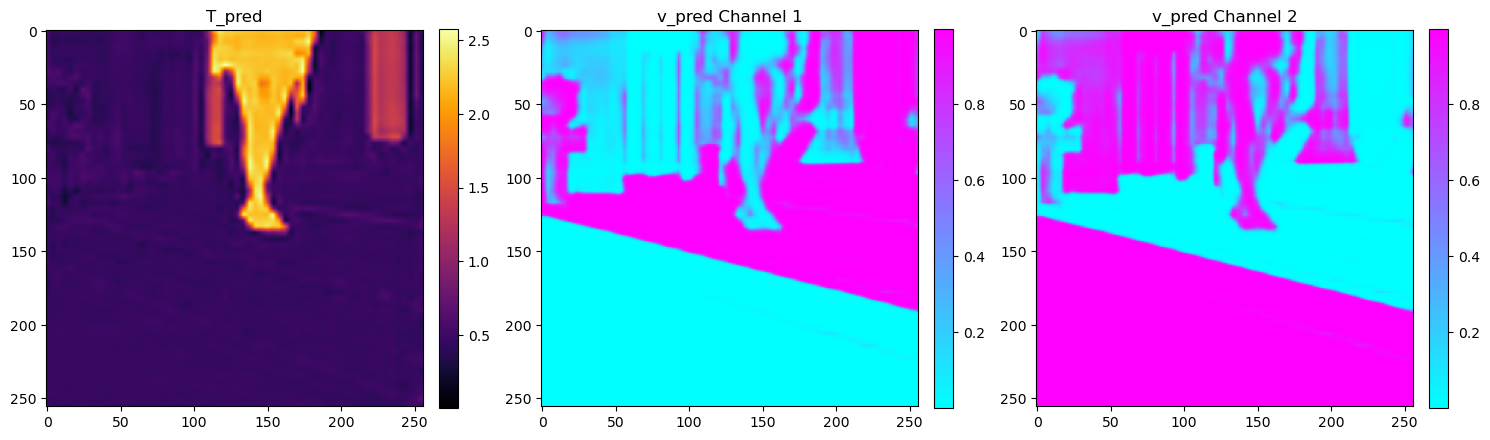

In [ ]:
# Determine the number of columns based on the availability of T_pred and v_pred
num_cols = (1 if T_pred is not None else 0) + (v_pred.shape[1] if v_pred is not None else 0)

# Crear una figura con 1 fila y num_cols columnas
plt.figure(figsize=(15, 5))

# Plotear T_pred si está disponible
if T_pred is not None:
  plt.subplot(1, num_cols, 1)
  plt.imshow(T_pred[0, 0].cpu().numpy(), cmap='inferno')
  plt.title('T_pred')
  plt.colorbar(fraction=0.046, pad=0.04)

# Plotear v_pred si está disponible
if v_pred is not None:
  for i in range(v_pred.shape[1]):
    plt.subplot(1, num_cols, (1 if T_pred is not None else 0) + i + 1)
    plt.imshow(v_pred[0, i].cpu().numpy(), cmap='cool')
    plt.title(f'v_pred Channel {i+1}')
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [ ]:
e_pred[0, 0].shape

torch.Size([256, 256])

In [ ]:
print(e_pred[0, 0])

tensor([[-5.6140, -5.5506, -5.4871,  ..., -5.8937, -5.7649, -5.6362],
        [-5.5995, -5.4545, -5.3094,  ..., -5.6855, -5.4631, -5.2407],
        [-5.5850, -5.3583, -5.1317,  ..., -5.4774, -5.1613, -4.8452],
        ...,
        [-2.4939, -2.4198, -2.3457,  ..., -3.4510, -3.3437, -3.2364],
        [-2.5811, -2.5097, -2.4383,  ..., -3.4235, -3.3187, -3.2138],
        [-2.6682, -2.5996, -2.5309,  ..., -3.3960, -3.2936, -3.1913]],
       device='cuda:0')


In [ ]:
max_n_class = 30

def visualize_m(data, kind='pred'):
  assert kind in ['pred', 'gt']
  kind = 'Prediction' if kind == 'pred' else 'GT'

  hue = np.array([[0.5098],
          [0.6157],
          [0.8784],
          [0.0431],
          [0.0745],
          [0.1059],
          [0.3451],
          [0.0196],
          [0.1176],
          [0.5059],
          [0.0588],
          [0.0941],
          [0.5961],
          [0.5255],
          [0.0784],
          [0.0039],
          [0.5373],
          [0.1294],
          [0.4510],
          [0.1529],
          [0.1843],
          [0.4784],
          [0.0706],
          [0.0392],
          [0.3137],
          [0.8706],
          [0.5882],
          [0.9373],
          [0.0392],
          [0.1961]])

  sat = np.ones_like(hue) * 0.7
  val = np.ones_like(hue)

  hsv = np.concatenate((hue, sat, val), 1)
  rgb = mpl.colors.hsv_to_rgb(hsv)
  rgb = np.concatenate((rgb, np.ones((max_n_class, 1))), 1)

  mycmap = plt.get_cmap('gist_rainbow', max_n_class)

  plt.imshow(data, cmap=mycmap, vmin=0, vmax=max_n_class - 1)
  plt.title('Material map ' + kind)
  plt.axis('off')
  cbar = plt.colorbar()
  cbar.set_ticks([])
  plt.show()

  return eMap


In [ ]:
# from TeXNet.visualization import visualize_m

# Suponiendo que e_pred tiene la forma [1, 30, 256, 256]
# Aplicar torch.argmax para obtener las predicciones finales
e_pred = torch.argmax(e_pred, dim=1, keepdim=True)
print(f"e_pred shape after argmax: {e_pred.shape}")

# Convertir e_pred a un array de NumPy para su posterior procesamiento o visualización
e_pred_np = e_pred.squeeze(0).squeeze(0).cpu().numpy()
print(f"e_pred_np shape: {e_pred_np.shape}")


e_pred shape after argmax: torch.Size([1, 1, 256, 256])
e_pred_np shape: (256, 256)


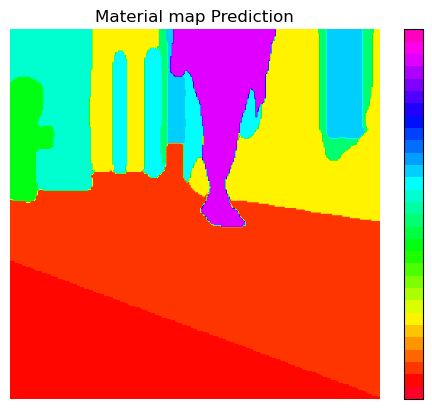

In [ ]:
# Visualizar el mapa de clases
eMap = visualize_m(e_pred_np, kind='pred')

In [ ]:
# Convertir eMap a un array de NumPy si no lo es ya
eMap_np = eMap.cpu().numpy() if isinstance(eMap, torch.Tensor) else eMap

# Obtener los índices únicos de los materiales en eMap
material_indices = np.unique(eMap_np)

print("Índices de los materiales en eMap:", material_indices)

Índices de los materiales en eMap: [ 1  2  3  6  9 11 12 13 14 16 17 18 27]
